In [283]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder,MultiLabelBinarizer, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import warnings
import json

warnings.filterwarnings("ignore")
pd.set_option('display.precision', 2)

YEAR = 2023
CUTOFF = 400
N_FOLDS = 5
RANDOM_STATE = 42

# 1. Prepare a dataset

In [284]:
df = pd.read_csv(f"stack-overflow-developer-survey-{YEAR}/survey_results_public.csv")

# Select the feature columns.
df = df[["Country", "EdLevel", "YearsCodePro", "Employment", "ConvertedCompYearly", "DevType", "OrgSize", "Age"]]
df = df.rename({"ConvertedCompYearly": "Salary"}, axis=1)
df.head()

,Country,EdLevel,YearsCodePro,Employment,Salary,DevType,OrgSize,Age
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18-24 years old
1,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",9,"Employed, full-time",285000.0,"Senior Executive (C-Suite, VP, etc.)",2 to 9 employees,25-34 years old
2,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",23,"Employed, full-time",250000.0,"Developer, back-end","5,000 to 9,999 employees",45-54 years old
3,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",7,"Employed, full-time",156000.0,"Developer, front-end",100 to 499 employees,25-34 years old
4,Philippines,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,"Employed, full-time;Independent contractor, fr...",23456.0,"Developer, full-stack",20 to 99 employees,25-34 years old


In [285]:
# Remove NaN values
dropped_df = df.dropna()
print(dropped_df.isna().sum())
print(f"Total: {dropped_df.shape}")

Country         0
EdLevel         0
YearsCodePro    0
Employment      0
Salary          0
DevType         0
OrgSize         0
Age             0
dtype: int64
Total: (47701, 8)


In [286]:
# Select only full-time employment.
dropped_df["full_time"] = dropped_df["Employment"].apply(lambda x: "full-time" in x)
dropped_df = dropped_df[dropped_df["full_time"]]

In [287]:
# Group minor countires into "Other".
def remove_minor_categories(categories, cutoff):
    categories_dict = {}
    for c,value in categories.items():
        if value >= cutoff:
            categories_dict[c] = c
        else:
            categories_dict[c] = 'Other'
    return categories_dict

countries_dict = remove_minor_categories(dropped_df["Country"].value_counts(), CUTOFF)
dropped_df["Country"] = dropped_df["Country"].map(countries_dict).astype("category")
dropped_df = dropped_df[dropped_df["Country"] != "Other"]
dropped_df["Country"]
dropped_df["Country"].value_counts()

Country
United States of America                                11261
Germany                                                  3399
United Kingdom of Great Britain and Northern Ireland     3215
Canada                                                   1943
India                                                    1743
France                                                   1547
Brazil                                                   1113
Netherlands                                              1086
Australia                                                1071
Spain                                                    1019
Poland                                                    958
Sweden                                                    946
Italy                                                     876
Switzerland                                               539
Denmark                                                   468
Norway                                                    457


In [288]:
# Group minor types of dev into "Other".
dev_dict = remove_minor_categories(dropped_df["DevType"].value_counts(), CUTOFF)
dropped_df["DevType"] = dropped_df["DevType"].map(dev_dict)
dropped_df["DevType"] = dropped_df["DevType"].apply(lambda x: "Other" if "Other" in x else x).astype("category")
dropped_df["DevType"].value_counts()

DevType
Developer, full-stack                            11546
Developer, back-end                               6486
Other                                             3819
Developer, front-end                              2084
Developer, desktop or enterprise applications     1680
Engineering manager                               1035
Developer, mobile                                 1003
Developer, embedded applications or devices        991
DevOps specialist                                  720
Data scientist or machine learning specialist      719
Engineer, data                                     657
Research & Development role                        606
Cloud infrastructure engineer                      603
Senior Executive (C-Suite, VP, etc.)               525
Academic researcher                                462
Name: count, dtype: int64

In [289]:
# Change years of experience into number.
def experience2number(year):
    if year == "Less than 1 year":
        return 0
    elif year == "More than 50 years":
        return 50
    else:
        return year

dropped_df["YearsCodePro"] = dropped_df["YearsCodePro"].apply(experience2number).astype(int)

In [290]:
# Group the educational level.
def group_EdLevel(x):
    if "Bachelor" in x:
        return "Bachelor's degree"
    elif "Master" in x:
        return "Master's degree"
    elif "Professional degree" in x:
        return "Professional degree"
    return "Other"

dropped_df["EdLevel"] = dropped_df["EdLevel"].apply(group_EdLevel).astype("category")

In [291]:
# Remove outliers using IQR (Inter Quartile Range)
q1 = dropped_df['Salary'].quantile(0.25)
q3 = dropped_df['Salary'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr

filtered_df = dropped_df[(dropped_df["Salary"]>lower) & (dropped_df["Salary"]<upper)]
filtered_df = filtered_df[filtered_df["YearsCodePro"]<=30]
print(filtered_df.shape)

(30562, 9)


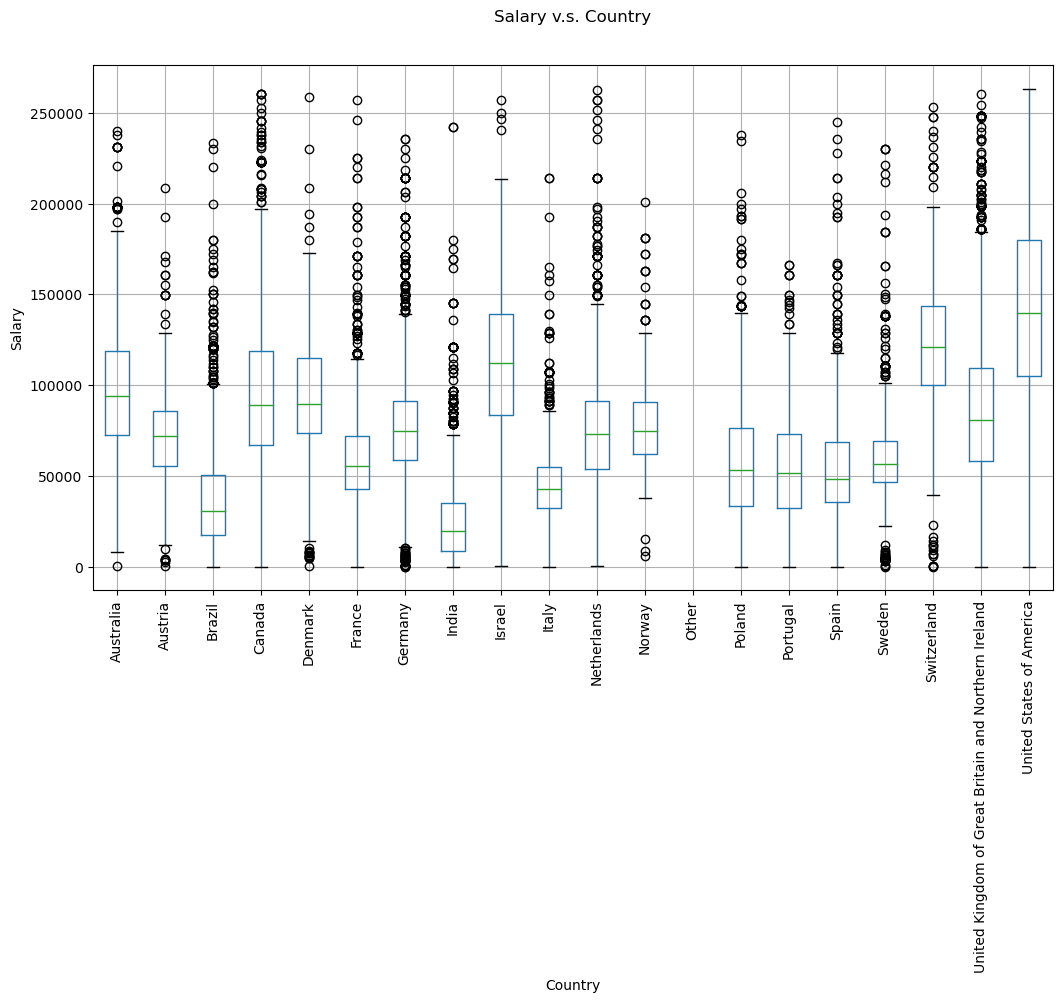

In [292]:
fig, ax = plt.subplots(1,1, figsize=(12, 7))
filtered_df.boxplot('Salary', 'Country', ax=ax)
plt.suptitle('Salary v.s. Country')
plt.title('')
plt.ylabel('Salary')
plt.xticks(rotation=90)
plt.show()

In [293]:
filtered_df["OrgSize"] = filtered_df["OrgSize"].astype("category")
filtered_df["Age"] = filtered_df["Age"].astype("category")

In [294]:
numeric_cols = [ "YearsCodePro"]
categorical_cols = ["Country", "EdLevel", "DevType", "OrgSize", "Age"]
target_col = "Salary"

In [320]:
choice_dict = {}

for col in categorical_cols:
    choice_dict[col] = list(filtered_df[col].unique())

In [321]:
with open("choices.json", "w") as file:
    json.dump(choice_dict, file)

In [319]:
choice_dict["DevType"]

['Developer, back-end',
 'Developer, front-end',
 'Developer, full-stack',
 'Other',
 'Data scientist or machine learning specialist',
 'Research & Development role',
 'Developer, desktop or enterprise applications',
 'Engineer, data',
 'Developer, embedded applications or devices',
 'Engineering manager',
 'Cloud infrastructure engineer',
 'Developer, mobile',
 'DevOps specialist',
 'Senior Executive (C-Suite, VP, etc.)',
 'Academic researcher']

# 2. Train the model

In [297]:
compare_models_result = {}

In [298]:
def create_folds(df, n_folds):
    df["fold"] = -1
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)
    for i, (train , val) in enumerate(kf.split(X=df, y=df["Salary"].values)):
        df.loc[val, 'fold'] = i
    return df

train_df = filtered_df.copy().reset_index(drop=True)
train_df = create_folds(train_df, N_FOLDS)
train_df["fold"].value_counts()

fold
0    6113
1    6113
2    6112
4    6112
3    6112
Name: count, dtype: int64

In [299]:
train_df = pd.concat(
    (train_df, pd.get_dummies(train_df[categorical_cols])),
    axis=1
    )

### Linear Regression

In [300]:
drop_cols = categorical_cols + ["Employment","Salary","DevType",'OrgSize', 'Age','fold']
oof_df = pd.DataFrame()
result_dict = {
    "fold":[],
    "mae":[],
    "rmse":[],
    "mape":[]
}

for fold in tqdm(range(N_FOLDS)):
    train_data = train_df[train_df['fold']!=fold].reset_index(drop=True)
    val_data = train_df[train_df['fold']==fold].reset_index(drop=True)

    X_train = train_data.drop(columns=drop_cols)
    y_train = train_data[target_col]
    X_val = val_data.drop(columns=drop_cols)
    y_val = val_data[target_col]
    

    model = LinearRegression()
    model.fit(X_train, y_train)

    prediction = model.predict(X_val)
    val_data["pred"] = prediction
    oof_df = pd.concat([oof_df,val_data])

    mae = mean_absolute_error(y_true=y_val, y_pred=prediction)
    mse = mean_squared_error(y_true=y_val, y_pred=prediction)
    mape = mean_absolute_percentage_error(y_true=y_val, y_pred=prediction)
    result_dict["fold"].append(fold)
    result_dict["mae"].append(mae)
    result_dict["rmse"].append(mse**(1/2))
    result_dict["mape"].append(mape)


100%|██████████| 5/5 [00:00<00:00, 12.13it/s]


In [301]:
result_df = pd.DataFrame(result_dict)
result_df

,fold,mae,rmse,mape
0,0,25882.63,35211.17,11.20
1,1,25652.78,35115.70,23.36
2,2,25872.32,35841.36,7.18
3,3,26476.37,36156.42,29.08
4,4,25654.96,35308.00,19.14


In [302]:
compare_models_result["Linear Regression"] = result_df.drop(columns="fold").mean().to_dict()

### Random Forest

In [303]:
drop_cols = categorical_cols + ["Employment","Salary","DevType",'OrgSize', 'Age','fold']
oof_df = pd.DataFrame()
result_dict = {
    "fold":[],
    "mae":[],
    "rmse":[],
    "mape":[]
}

for fold in tqdm(range(N_FOLDS)):
    train_data = train_df[train_df['fold']!=fold].reset_index(drop=True)
    val_data = train_df[train_df['fold']==fold].reset_index(drop=True)

    X_train = train_data.drop(columns=drop_cols)
    y_train = train_data[target_col]
    X_val = val_data.drop(columns=drop_cols)
    y_val = val_data[target_col]
    

    model = RandomForestRegressor(random_state=RANDOM_STATE)
    model.fit(X_train, y_train)

    prediction = model.predict(X_val)
    val_data["pred"] = prediction
    oof_df = pd.concat([oof_df,val_data])

    mae = mean_absolute_error(y_true=y_val, y_pred=prediction)
    mse = mean_squared_error(y_true=y_val, y_pred=prediction)
    mape = mean_absolute_percentage_error(y_true=y_val, y_pred=prediction)
    result_dict["fold"].append(fold)
    result_dict["mae"].append(mae)
    result_dict["rmse"].append(mse**(1/2))
    result_dict["mape"].append(mape)


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:29<00:00,  5.93s/it]


In [304]:
result_df = pd.DataFrame(result_dict)
result_df

,fold,mae,rmse,mape
0,0,27045.36,37762.80,13.50
1,1,27106.77,37690.90,32.25
2,2,27343.37,38641.74,7.16
3,3,26886.70,37913.84,30.90
4,4,27204.32,37864.17,19.63


In [305]:
compare_models_result["Random Forest"] = result_df.drop(columns="fold").mean().to_dict()

### LightGBM

In [306]:
params = {
    'random_state': RANDOM_STATE,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 5,
    "verbose":-1
}

In [307]:
feature_cols = categorical_cols + numeric_cols
oof_df = pd.DataFrame()
result_dict = {
    "fold":[],
    "mae":[],
    "rmse":[],
    "mape":[]
}

for fold in range(N_FOLDS):
    train_data = train_df[train_df['fold']!=fold].reset_index(drop=True)
    val_data = train_df[train_df['fold']==fold].reset_index(drop=True)

    X_train = train_data[feature_cols]
    y_train = train_data[target_col]
    X_val = val_data[feature_cols]
    y_val = val_data[target_col]
    
    dtrain = lgb.Dataset(X_train, y_train, categorical_feature=categorical_cols)
    dval = lgb.Dataset(X_val, y_val, categorical_feature=categorical_cols)

    model = lgb.train(
        params,
        train_set=dtrain,
        valid_sets=dval,
        callbacks=[
            lgb.log_evaluation(20),
            ],
        )

    prediction = model.predict(X_val)
    val_data["pred"] = prediction
    oof_df = pd.concat([oof_df,val_data])

    mae = mean_absolute_error(y_true=y_val, y_pred=prediction)
    mse = mean_squared_error(y_true=y_val, y_pred=prediction)
    mape = mean_absolute_percentage_error(y_true=y_val, y_pred=prediction)
    result_dict["fold"].append(fold)
    result_dict["mae"].append(mae)
    result_dict["rmse"].append(mse**(1/2))
    result_dict["mape"].append(mape)


[20]	valid_0's rmse: 38729.3
[40]	valid_0's rmse: 35291.7
[60]	valid_0's rmse: 34493.6
[80]	valid_0's rmse: 34216.7
[100]	valid_0's rmse: 34107.8
[20]	valid_0's rmse: 38624.3
[40]	valid_0's rmse: 35217.4
[60]	valid_0's rmse: 34415.2
[80]	valid_0's rmse: 34156.7
[100]	valid_0's rmse: 34049.9
[20]	valid_0's rmse: 39029.6
[40]	valid_0's rmse: 35818.3
[60]	valid_0's rmse: 35102
[80]	valid_0's rmse: 34899.3
[100]	valid_0's rmse: 34816.4
[20]	valid_0's rmse: 39022.2
[40]	valid_0's rmse: 35689.9
[60]	valid_0's rmse: 34955.4
[80]	valid_0's rmse: 34723.7
[100]	valid_0's rmse: 34637
[20]	valid_0's rmse: 38698.9
[40]	valid_0's rmse: 35509
[60]	valid_0's rmse: 34831.6
[80]	valid_0's rmse: 34631.8
[100]	valid_0's rmse: 34553.9


In [308]:
result_df = pd.DataFrame(result_dict)
result_df

,fold,mae,rmse,mape
0,0,24498.20,34107.76,11.39
1,1,24383.80,34049.92,24.86
2,2,24543.74,34816.42,7.57
3,3,24789.53,34636.95,29.12
4,4,24712.97,34553.87,18.50


In [309]:
result_df.drop(columns="fold").mean().to_dict()

{'mae': 24585.64631120385,
 'rmse': 34432.98229690315,
 'mape': 18.288937854787683}

In [310]:
compare_models_result["LightGBM"] = result_df.drop(columns="fold").mean().to_dict()

# Result

In [311]:
result_df = pd.DataFrame(compare_models_result).round(2)

In [312]:
result_df.style.highlight_min(color = 'lightgreen', axis=1)

,Linear Regression,Random Forest,LightGBM
mae,25907.810000,27117.300000,24585.650000
rmse,35526.530000,37974.690000,34432.980000
mape,17.990000,20.690000,18.290000


In [313]:
# Save the LightGBM model.
train_data = train_df[train_df['fold']!=fold].reset_index(drop=True)
X_train = train_data[feature_cols]
y_train = train_data[target_col]

dtrain = lgb.Dataset(X_train, y_train, categorical_feature=categorical_cols)

model = lgb.train(
    params,
    train_set=dtrain,
    callbacks=[
        lgb.log_evaluation(20),
        ],
    )
model.save_model(f'model.txt')